In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from functools import partial
from IPython import get_ipython

In [2]:
#dimensions of our images
height=63
width=63

In [3]:
##RUN SETUP
### starting params
#normalize data?
normalize=True
#object type for labeling model in storage
#also for loading correct data files for training images
obj='GALAXY'
#tag for unique model saving and loading
tag='norm_TEST'
#path to save and/or load model data 
save_path="./bin/model/"+obj+"_SAVE_"+tag
#do we want to 
#  load in data
#  train and save model with data
encode=True
#  load model from memory
#  run image data through model
decode=True

In [4]:
# To plot figures
#get_ipython().run_line_magic('matplotlib', 'inline')
def plot_image(image, shape=[width, height], cmap = "Greys_r"):
    plt.imshow(image.reshape(shape), cmap=cmap,interpolation="nearest")
    plt.axis("off")   

In [5]:
#importing training images
#currently data csv is hard coded, will fix later
if encode: 
    import pandas 
    df = pandas.read_csv("./bin/data/GALAXY_data_size_63.csv", header=None)
    df=df.values
    temp=df.flatten()
    temp=np.array_split(temp,1500)
    train_images=np.array(temp)
    train_images.resize(1500,63,63)
    size=train_images.shape[0]
    temp=train_images.flatten()
    temp=np.array_split(temp,size)
    input_data=np.array(temp)

In [6]:
#normalizing data to 0-1 scale
def normalize_data(data):
    #find max and min of data
    maxi=0.0
    mini=0.0
    for i in range(width):
        for j in range(height):
            if (data[i*width+j]>maxi):
                maxi=data[i*width+j]
            elif (data[i*width+j]<mini):
                mini=data[i*width+j]
    #normalize all data by dividing my max
    for i in range(width):
        for j in range(height):
            data[i*width+j]=(data[i*width+j]-mini)/(maxi-mini)
    return data

In [7]:
#unused
def clean_baseline(data):
    for i in range(width):
        for j in range(height):
            if data[i*width+j]<0:
                data[i*width+j]=0
    return data

In [8]:
#normalize training images according to starting params
if normalize and encode:
    for image in input_data:
        normalize_data(image)
        #not really working as intended so removing clean_baseline
        #clean_baseline(image)

In [9]:
#building dataset
### params
n_inputs=width*height
input_layer=tf.placeholder('float',[None,n_inputs])
batch_size = tf.placeholder(tf.int64)
BATCH_SIZE=1
### dataset
dataset = tf.data.Dataset.from_tensor_slices(input_layer).repeat().batch(batch_size)

In [10]:
#iterator
iter = dataset.make_initializable_iterator() # create the iteratorfeatures = iter.get_next()
features=iter.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
#making the 
#net defining paramters

## Encoder
n_hidden_1 = 2300
n_hidden_2 = 1400

In [12]:
## Decoder
n_hidden_3 = n_hidden_1
n_outputs = n_inputs
#standard learning rates
learning_rate = 0.01
l2_reg = 0.0001

In [13]:
BATCH_SIZE = 30
### Number of batches :  length dataset / batch size
n_batches = input_data.shape[0] // BATCH_SIZE
#print(n_batches)
n_epochs = 50

In [14]:
## Define Xavier initialization
#experiment here
xav_init =  tf.contrib.layers.xavier_initializer()
## Define the L2 regularizer
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [15]:
#defining the layers
##using dense layer nn
dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=xav_init,
                         kernel_regularizer=l2_regularizer)

In [16]:
#define the architecture
## Make the mat mul
hidden_1=dense_layer(features, n_hidden_1)
hidden_2=dense_layer(hidden_1, n_hidden_2)
hidden_3=dense_layer(hidden_2, n_hidden_3)
outputs=dense_layer(hidden_3, n_outputs, activation=None)

Instructions for updating:
Use keras.layers.dense instead.


In [17]:
#mean-square loss fn
loss=tf.reduce_mean(tf.square(outputs-features))

In [18]:
#optimizer
loss = tf.reduce_mean(tf.square(outputs - features))
#Adam optimizer
#learning rate may not be optimized for Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

In [19]:
#to save model we use tf saver 
saver = tf.train.Saver()

In [20]:
import os

In [21]:
if encode:
    #saving training progress to file in ./bin/
    if os.path.isfile('./bin/log_'+tag+'.txt'): 
        print('Log file found. Writing training progress to ./bin/log_'+tag+'.txt')
        file=open('./bin/log_'+tag+'.txt','a')
    else:
        print('No log file found. Creating new file in ./bin/log_'+tag+'.txt...')
        file=open('./bin/log_'+tag+'.txt','w')
    #now running net with our architecture 
    with tf.Session() as sess:
        #initialize
        sess.run(tf.global_variables_initializer())
        # initialize iterator with train data
        sess.run(iter.initializer, feed_dict={input_layer: input_data,
                                              batch_size: BATCH_SIZE})
        #look for session to restore according to save_path
        #output accordingly
        try:
            saver.restore(sess, save_path)
        except ValueError:
            print('No saved model found. Creating new model...')
        else:
            print('Saved model found. Training model...')
        #print(sess.run(features).shape) 
        #train
        for epoch in range(n_epochs):       
            for iteration in range(n_batches):
                sess.run(train)
            if epoch % 1 == 0:
                loss_train = loss.eval()   # not shown
                #print loss and save this to log file
                print("\r{}".format(epoch), "Train MSE:", loss_train) 
                file.write(str("\r{}".format(epoch))+ " Train MSE: "+str(loss_train)+"\n") 
                saver.save(sess,save_path)
                print('Model saved')
            #saver.save(sess, "./bin/model/my_model_all_layers.ckpt") 
        #save_path = saver.save(sess, "./bin/model/model.ckpt")    
        #print("Model saved in path: %s" % save_path) 
        #currenlty saving model each  epoch
        #this slows down our training time considerably, will change for more rigorous training
        saver.save(sess,save_path)
    #close log file
    file.close()

No log file found. Creating new file in ./bin/log_norm_TEST.txt...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
No saved model found. Creating new model...
0 Train MSE: 259.67114
Model saved
1 Train MSE: 163.97716
Model saved
2 Train MSE: 58.298946
Model saved
3 Train MSE: 47.04915
Model saved
4 Train MSE: 31.589748
Model saved
5 Train MSE: 15.110802
Model saved
6 Train MSE: 11.151797
Model saved
7 Train MSE: 6.2190876
Model saved
8 Train MSE: 4.3585334
Model saved
9 Train MSE: 1.4741788
Model saved
10 Train MSE: 0.94223726
Model saved
11 Train MSE: 0.52820635
Model saved
12 Train MSE: 0.41031367
Model saved
13 Train MSE: 0.15775818
Model saved
14 Train MSE: 0.37984315
Model saved
15 Train MSE: 3.1799357
Model saved
16 Train MSE: 0.24543807
Model saved
17 Train MSE: 0.068145186
Model saved
18 Train MSE: 0.12325729
Model saved
19 Train MSE: 0.097036
Model saved
20 Train MSE: 1.232171
Model saved
21 Train MSE: 0.028202482
Model saved
22 Train MSE

In [22]:
if decode:
    from astropy.coordinates import SkyCoord
    from astroquery.sdss import SDSS
    from astropy.wcs import WCS
    from astropy import units as u
    from astropy.nddata import Cutout2D
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


C:\Users\Joey\Anaconda3\lib\site-packages\astroquery\sdss\__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [23]:
if decode:
    #now trying to use test_images to check autoencoder
    #grabbing some well known objects to try and reconstruct
    def get_obj_data(ra,dec):
        # Coordinates from SDSS SQL search
        objCoord=SkyCoord(ra=ra*u.degree,dec=dec*u.degree)
        # Get SDSS images
        xObj = SDSS.query_region(objCoord, spectro=True)
        imgObj = SDSS.get_images(matches=xObj)
        image_i = imgObj[0][0]
        data_i = image_i.data
        # Get image coordinates
        wcs = WCS(image_i.header)
        # Cut the Field of view 25.0 x 25.0 arcsec
        FoV = np.array([25.0, 25.0])
        FoV_dimen = u.Quantity((FoV[0], FoV[1]), u.arcsec)
        cutout = Cutout2D(data_i, objCoord, FoV_dimen, wcs=wcs)
        wcs_cut = cutout.wcs
        #ret=[]
        #for i in cutout.data.size: ret.append(cutout.data[i])
        #plot(objCoord,cutout)
        #print(cutout.data.size)
        return cutout.data.astype(float)

In [24]:
if decode:
    #object1 to get is the GALAXY 587731511532060697
    ra1=18.87683906
    dec1=-0.86097998
    data1=get_obj_data(ra1,dec1)

C:\Users\Joey\Anaconda3\lib\site-packages\astroquery\sdss\core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


0.15087890625
(3969,)
0.15087890625
(1, 3969)
1.8203125


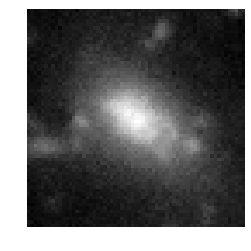

In [25]:
if decode:
    #plot_image(data1,shape=[width,height])
    test=data1.reshape((1, width*height))[0]
    print(np.amax(test[0]))
    #normalize_data(test)
    print(test.shape)
    print(np.amax(test[0]))
    test=test.reshape((1,width*height))
    print(test.shape)
    print(np.amax(test[0]))
    plot_image(test,shape=[width,height])

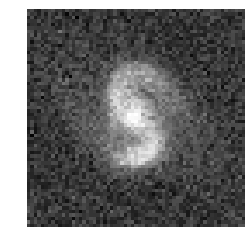

In [26]:
if decode:
    #object2 to get is random galaxy from SQL query
    ra2=132.486292926937
    dec2=51.1575638301083
    data2=get_obj_data(ra2,dec2)
    plot_image(data2,shape=[width,height])

In [37]:
if decode:
    #reconstructing image df[image_number]
    def reconstruct_image(image,number):
        ## Part 1: Reshape the image to the correct dimension i.e (1, w*h)
        ## first we reshape our image to work with normalize fn
        if normalize: 
            x_test = image.reshape((1, width*height))[0]
            normalize_data(x_test)
            print('Data max value: '+str(np.amax(x_test)))
            print('Data min value: '+str(np.amin(x_test)))
            print('Data mean value: '+str(np.mean(x_test)))
            # shape into (1, w*h) form
            x_test_1 = x_test.reshape((1, width*height))
        else: 
            x_test_1 = image.reshape((1, width*height))
            print('Data max value: '+str(np.amax(x_test_1)))
            print('Data min value: '+str(np.amin(x_test_1)))
            print('Data mean value: '+str(np.mean(x_test_1)))
        ## Part 2: Feed the model with the unseen image, encode/decode the image
        with tf.Session() as sess:     
            sess.run(tf.global_variables_initializer()) 
            sess.run(iter.initializer, feed_dict={input_layer: x_test_1,
                                          batch_size: 1})
        ## Part 3:  Print the real and reconstructed image
          # Restore variables from disk.
            saver.restore(sess, save_path)  
          # Reconstruct image
            outputs_val = outputs.eval()
        #print the original image
            fig=plt.figure(figsize=(width,height))
            plt.imshow(x_test_1.reshape(width,height))
            #plt.show
            fig.savefig('./bin/photo/'+str(number)+'_original_'+tag+'.png')
        #print encoding
            fig=plt.figure(figsize=(width,height))
            plt.imshow(outputs_val.reshape(width,height))
            #plt.show
            fig.savefig('./bin/photo/'+str(number)+'_decoded_'+tag+'.png')

Data max value: 1.0
Data min value: 0.061091738197424895
Data mean value: 0.23111309875245598
INFO:tensorflow:Restoring parameters from ./bin/model/GALAXY_SAVE_norm_TEST


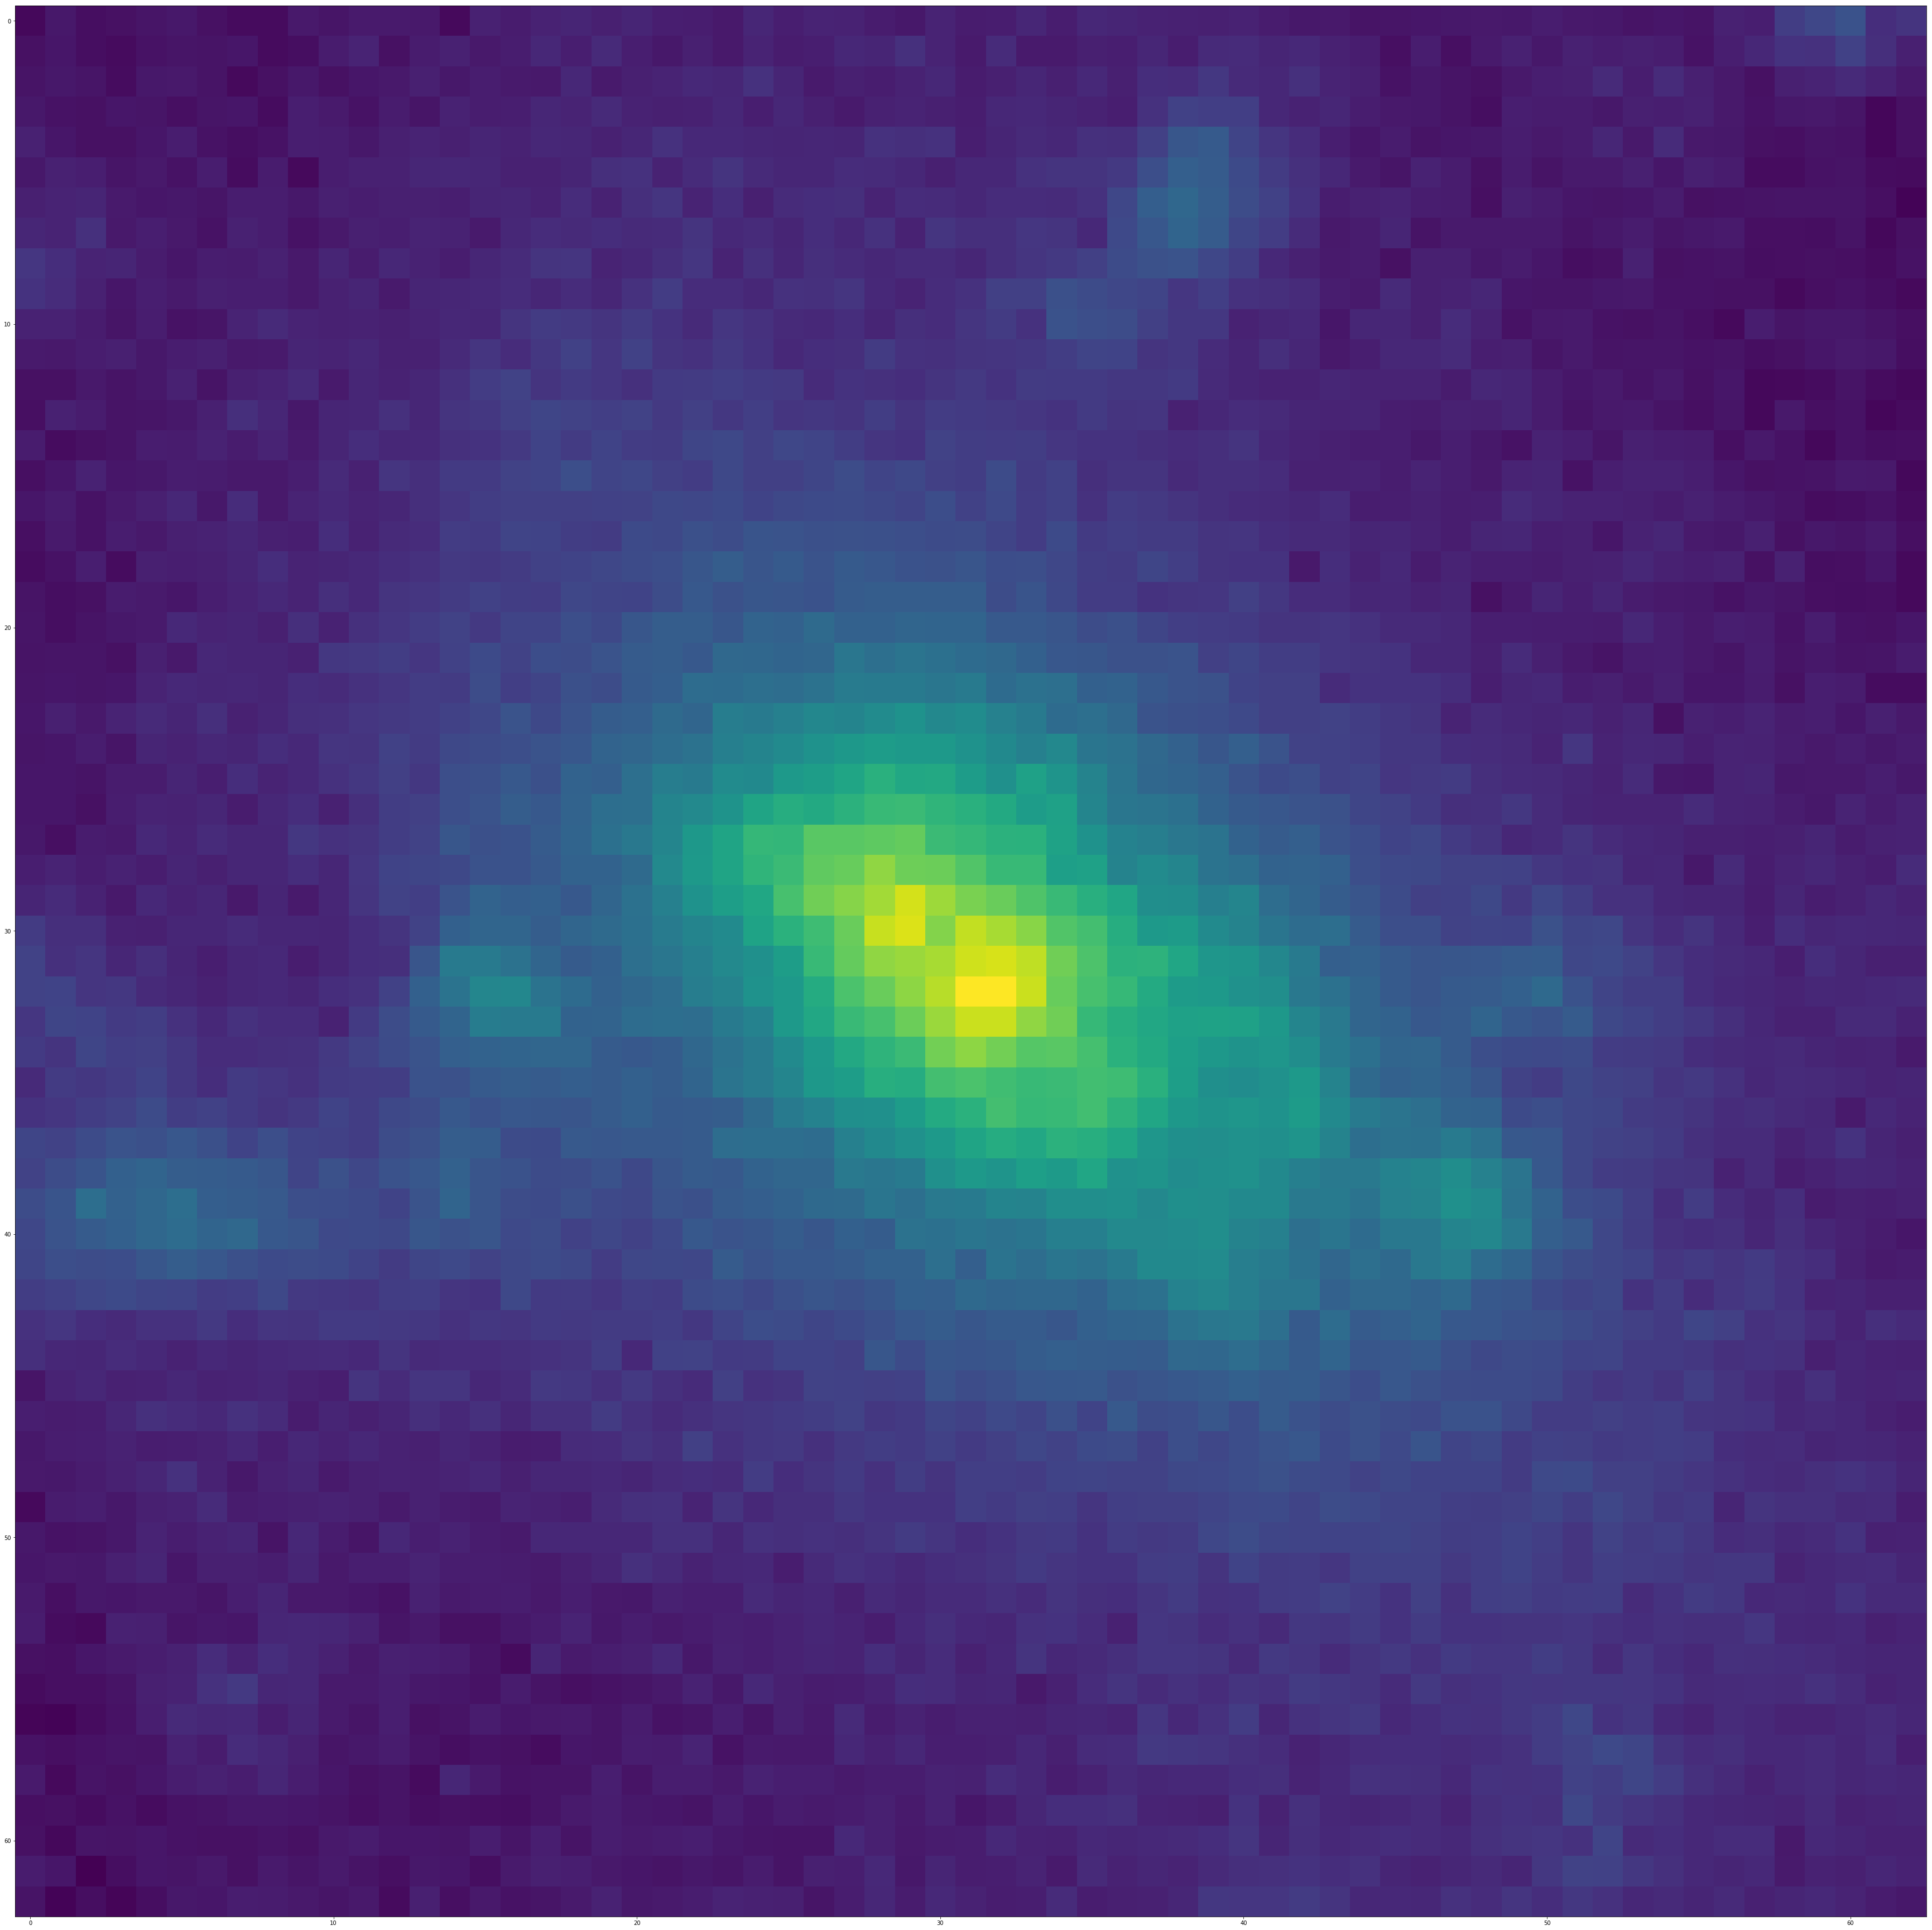

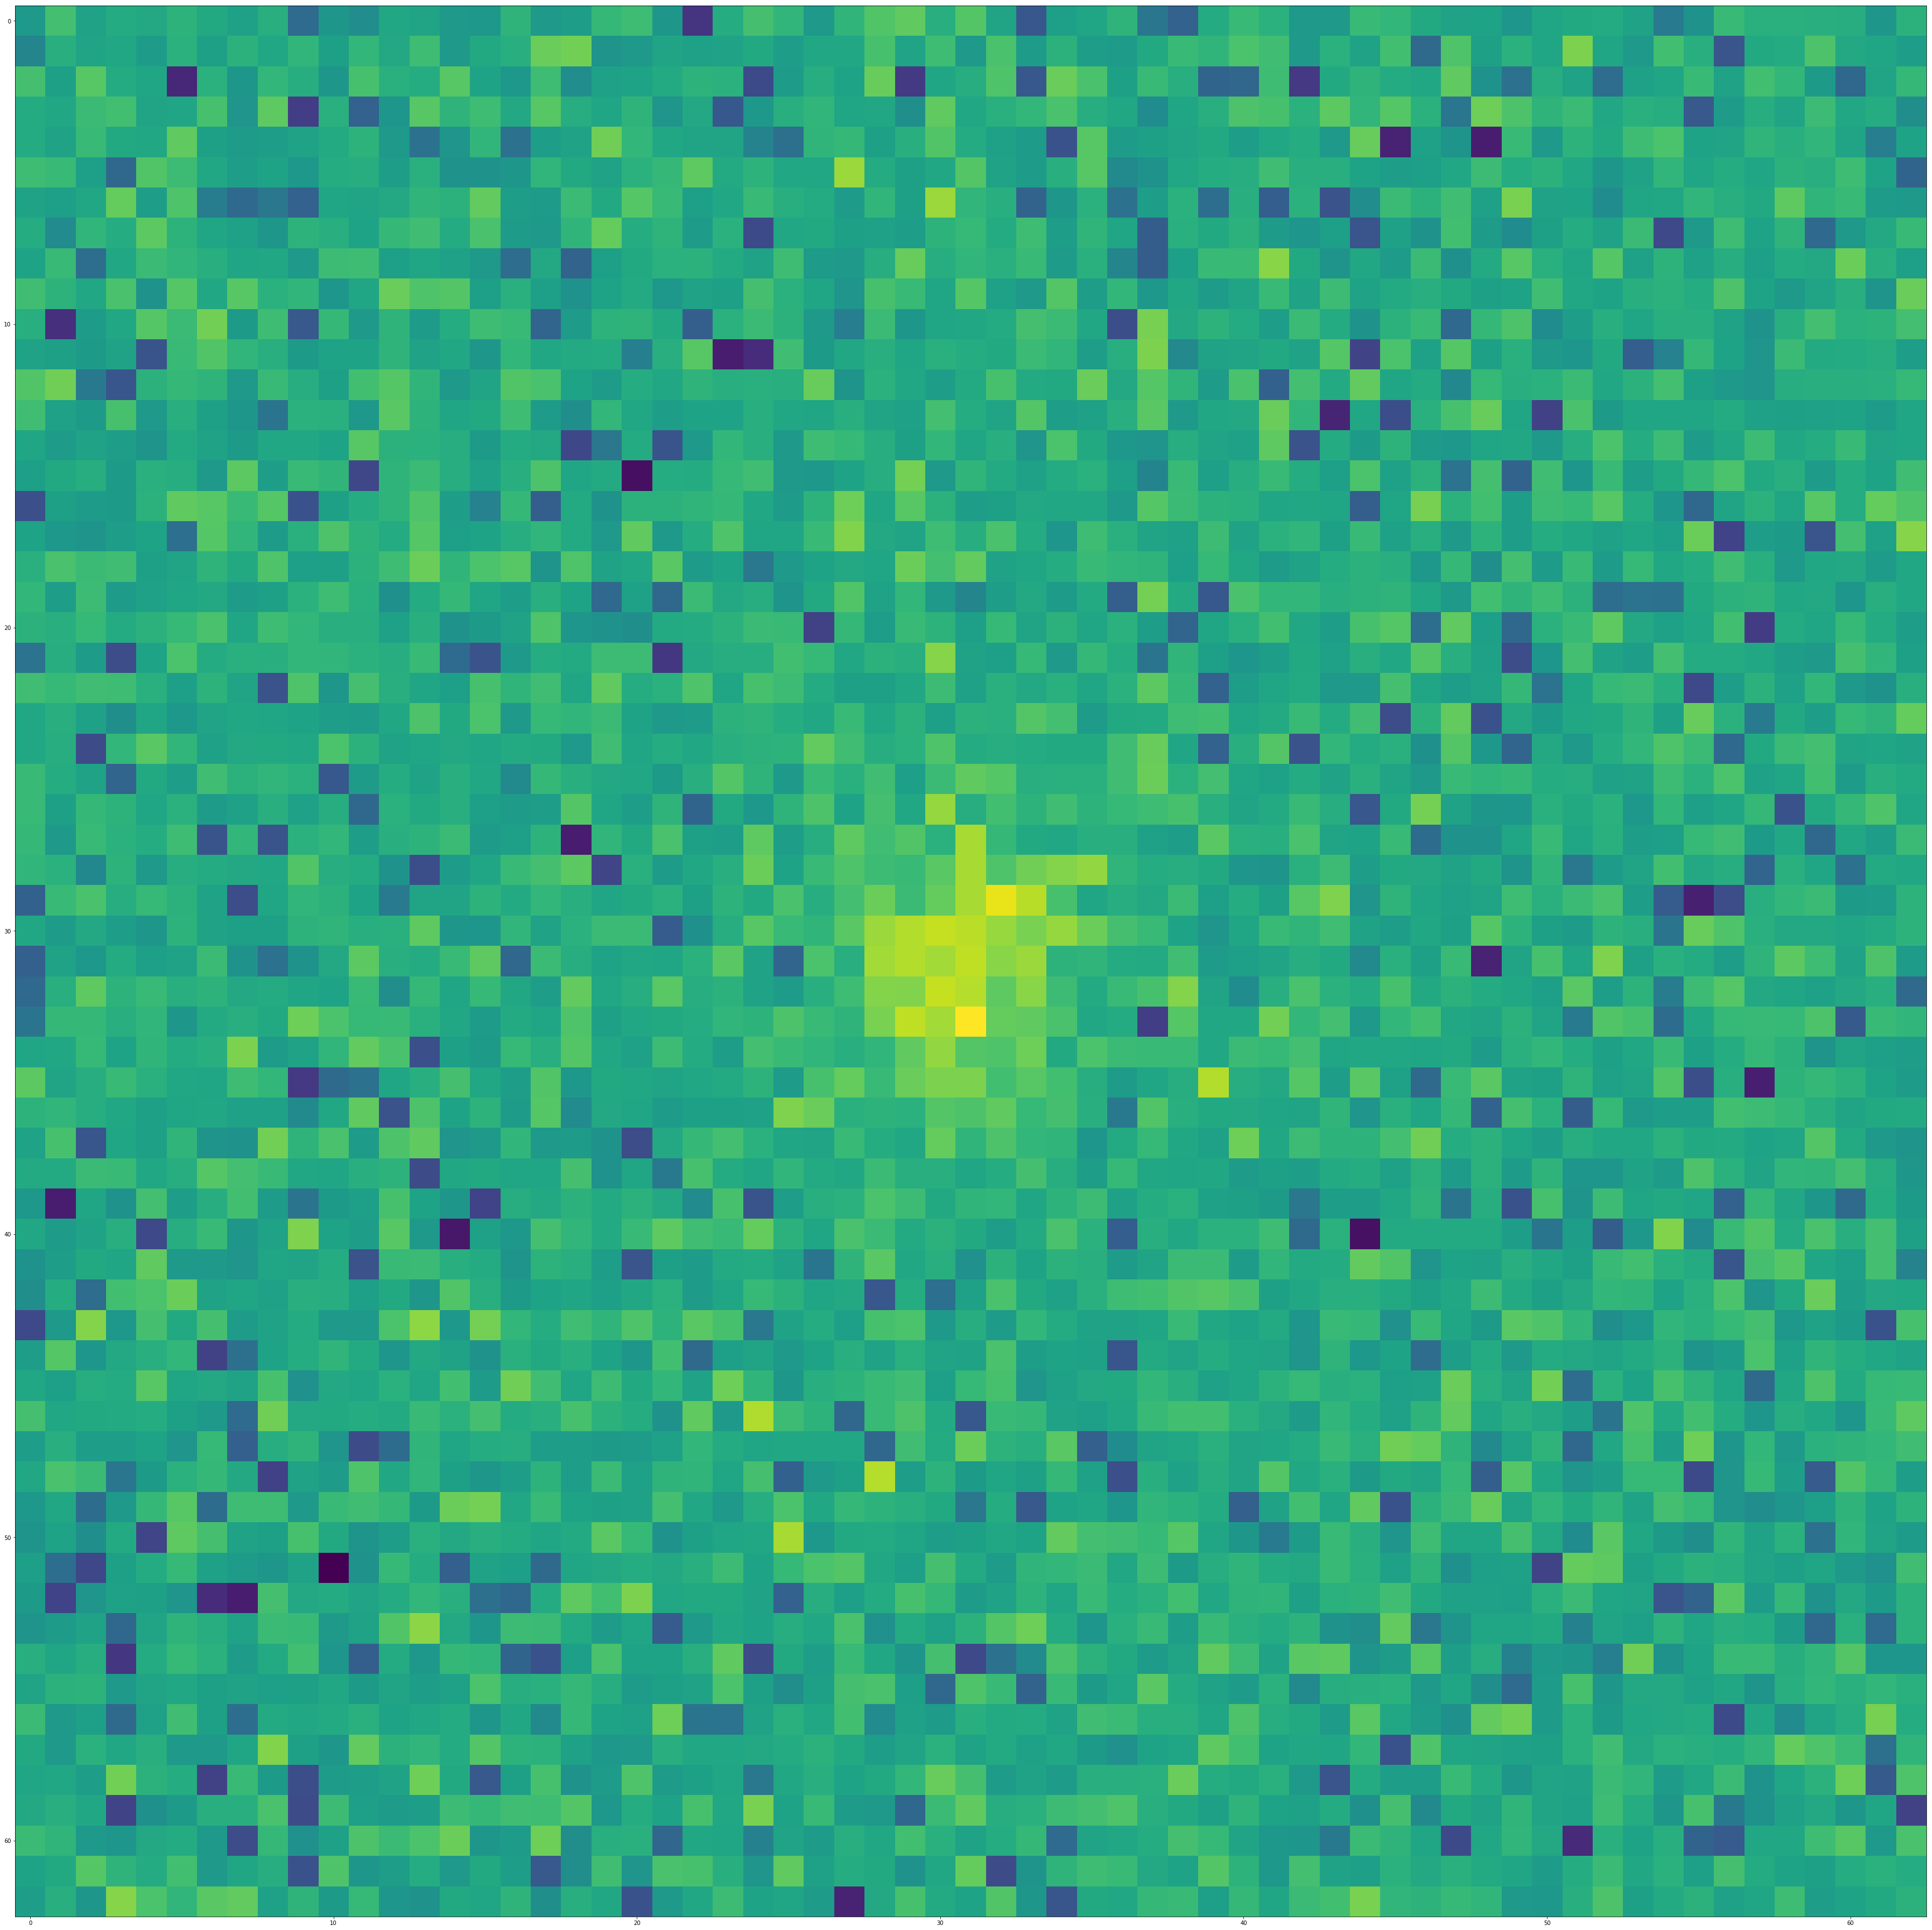

In [38]:
if decode:
    reconstruct_image(data1,1)

Data max value: 1.0
Data min value: 0.0
Data mean value: 0.24326298877325905
INFO:tensorflow:Restoring parameters from ./bin/model/GALAXY_SAVE_norm_TEST


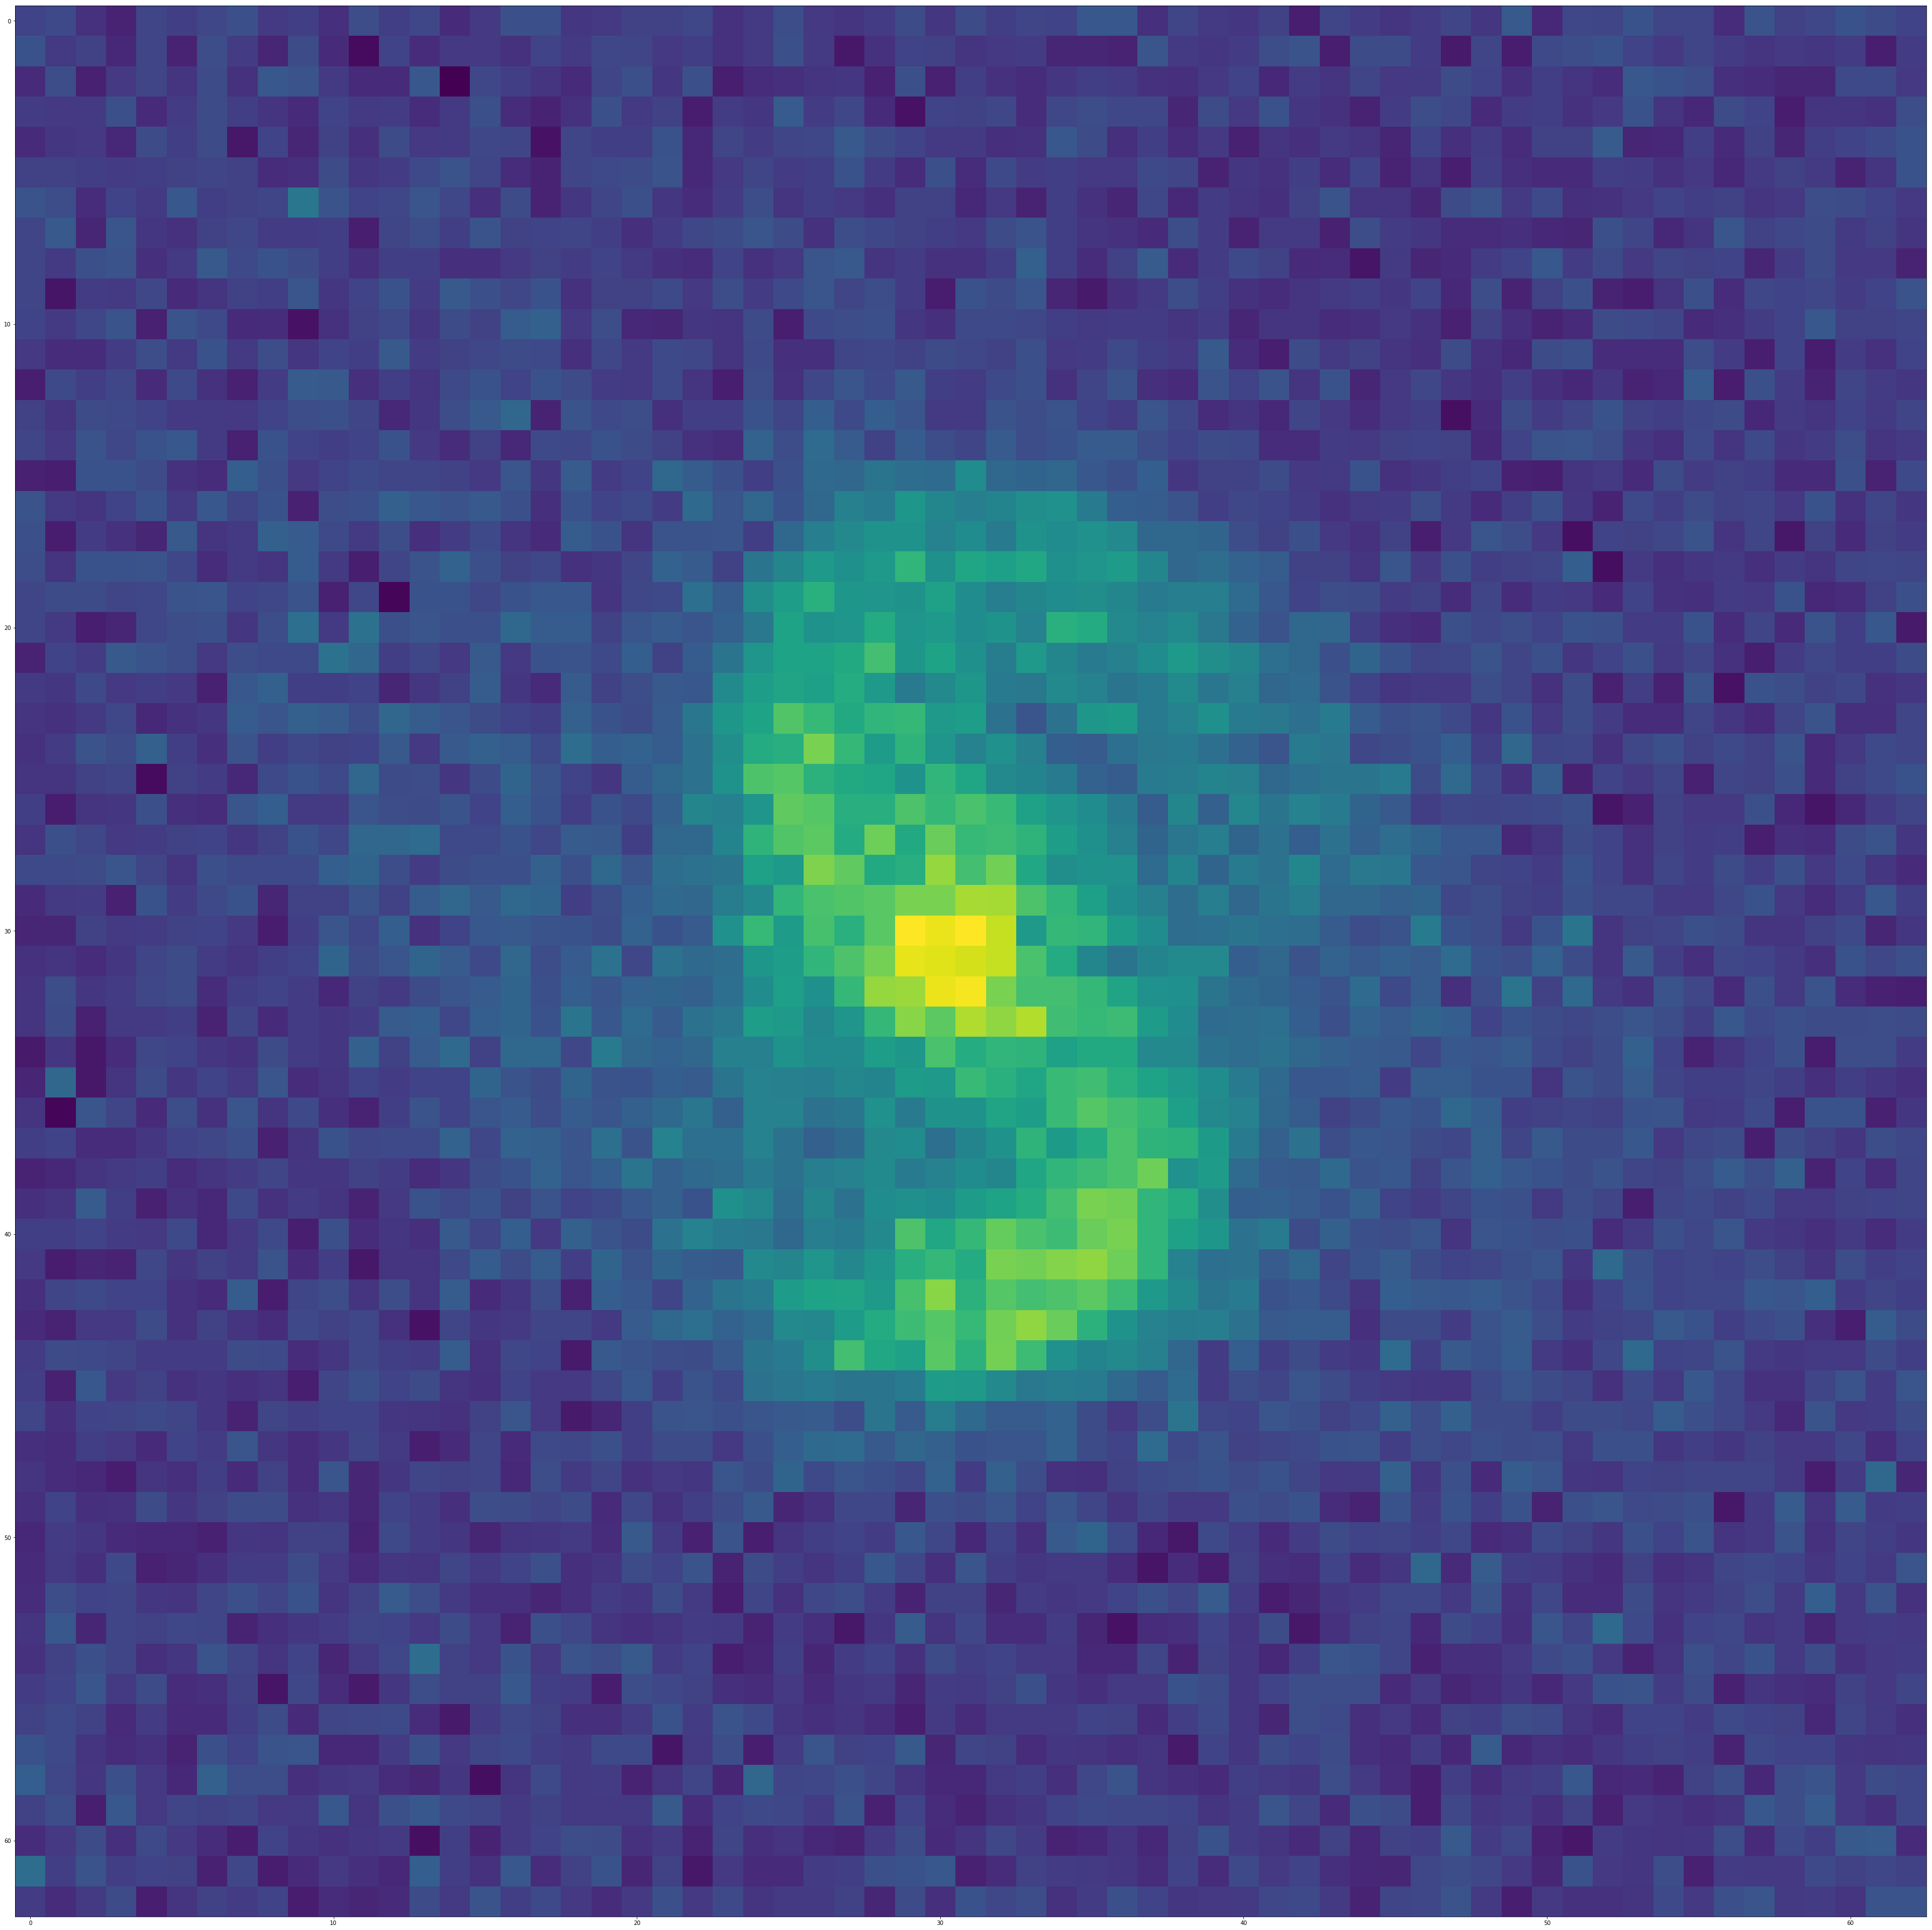

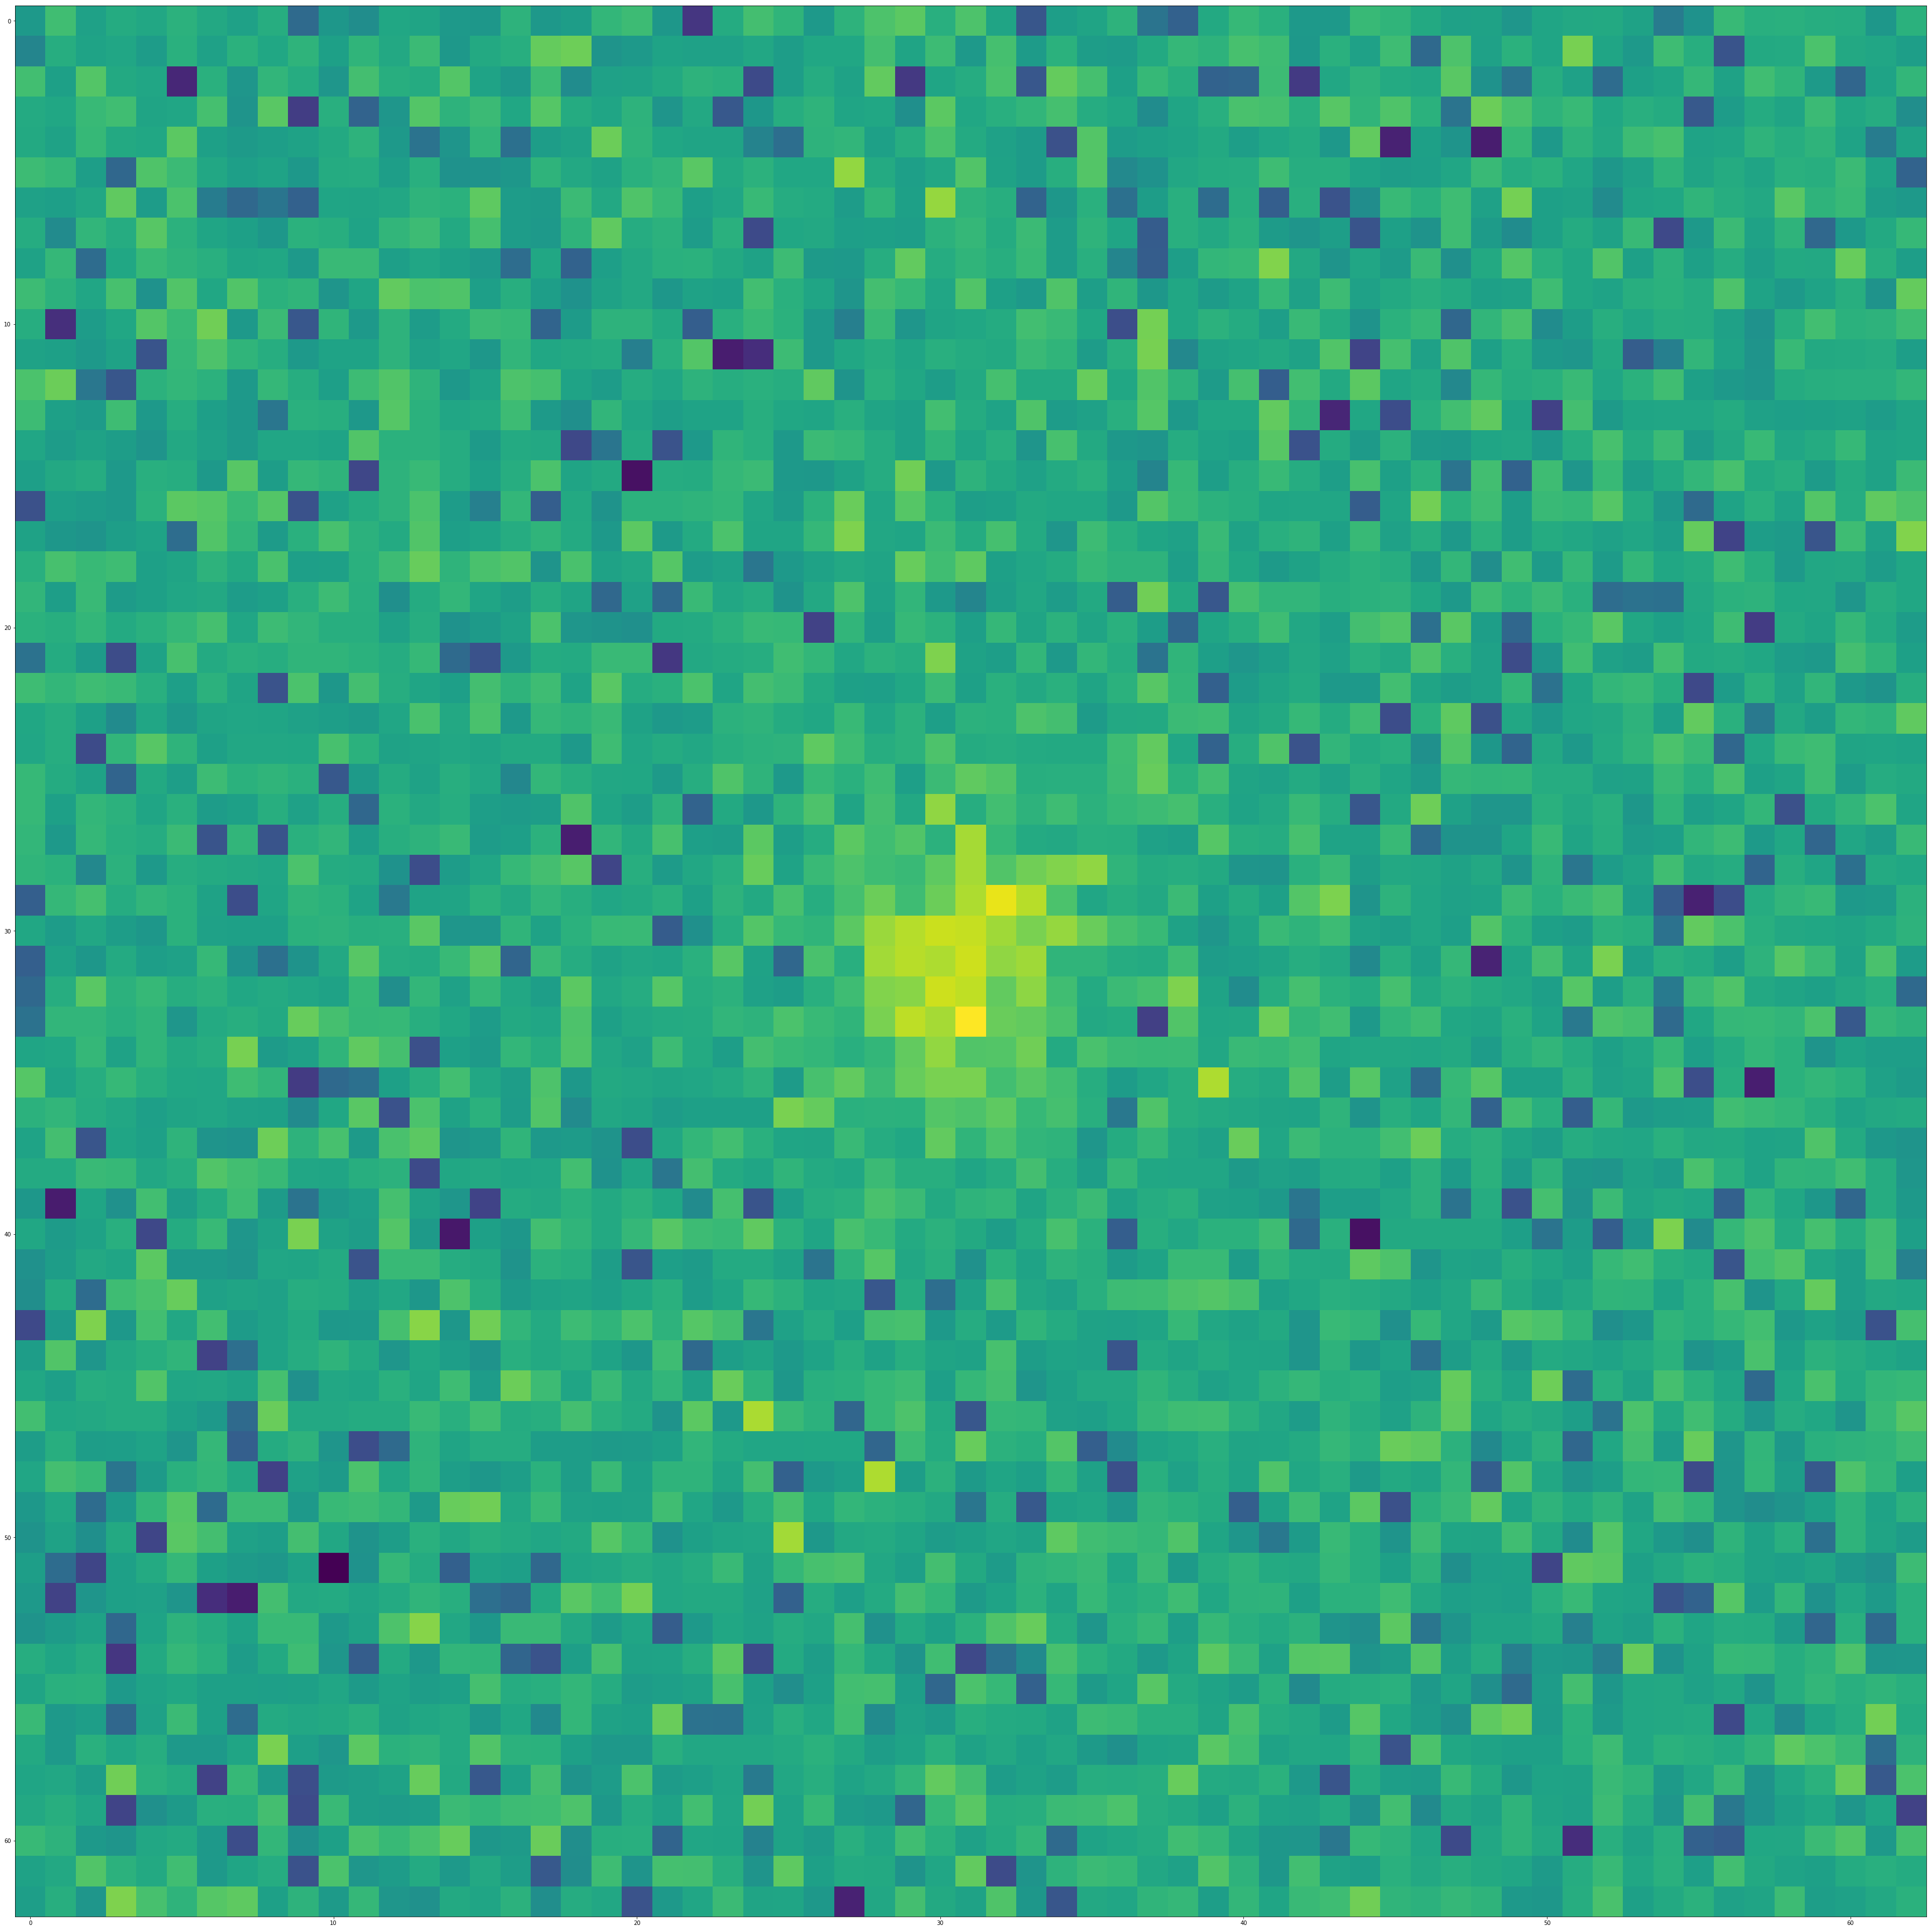

In [39]:
if decode:
    reconstruct_image(data2,2)

In [30]:
#it's sort of working, need more training images
#uh-oh it's the same image regardless of input?

Data max value: 1.0
Data min value: 0.0
Data mean value: 0.042809354512553015
INFO:tensorflow:Restoring parameters from ./bin/model/GALAXY_SAVE_norm_TEST


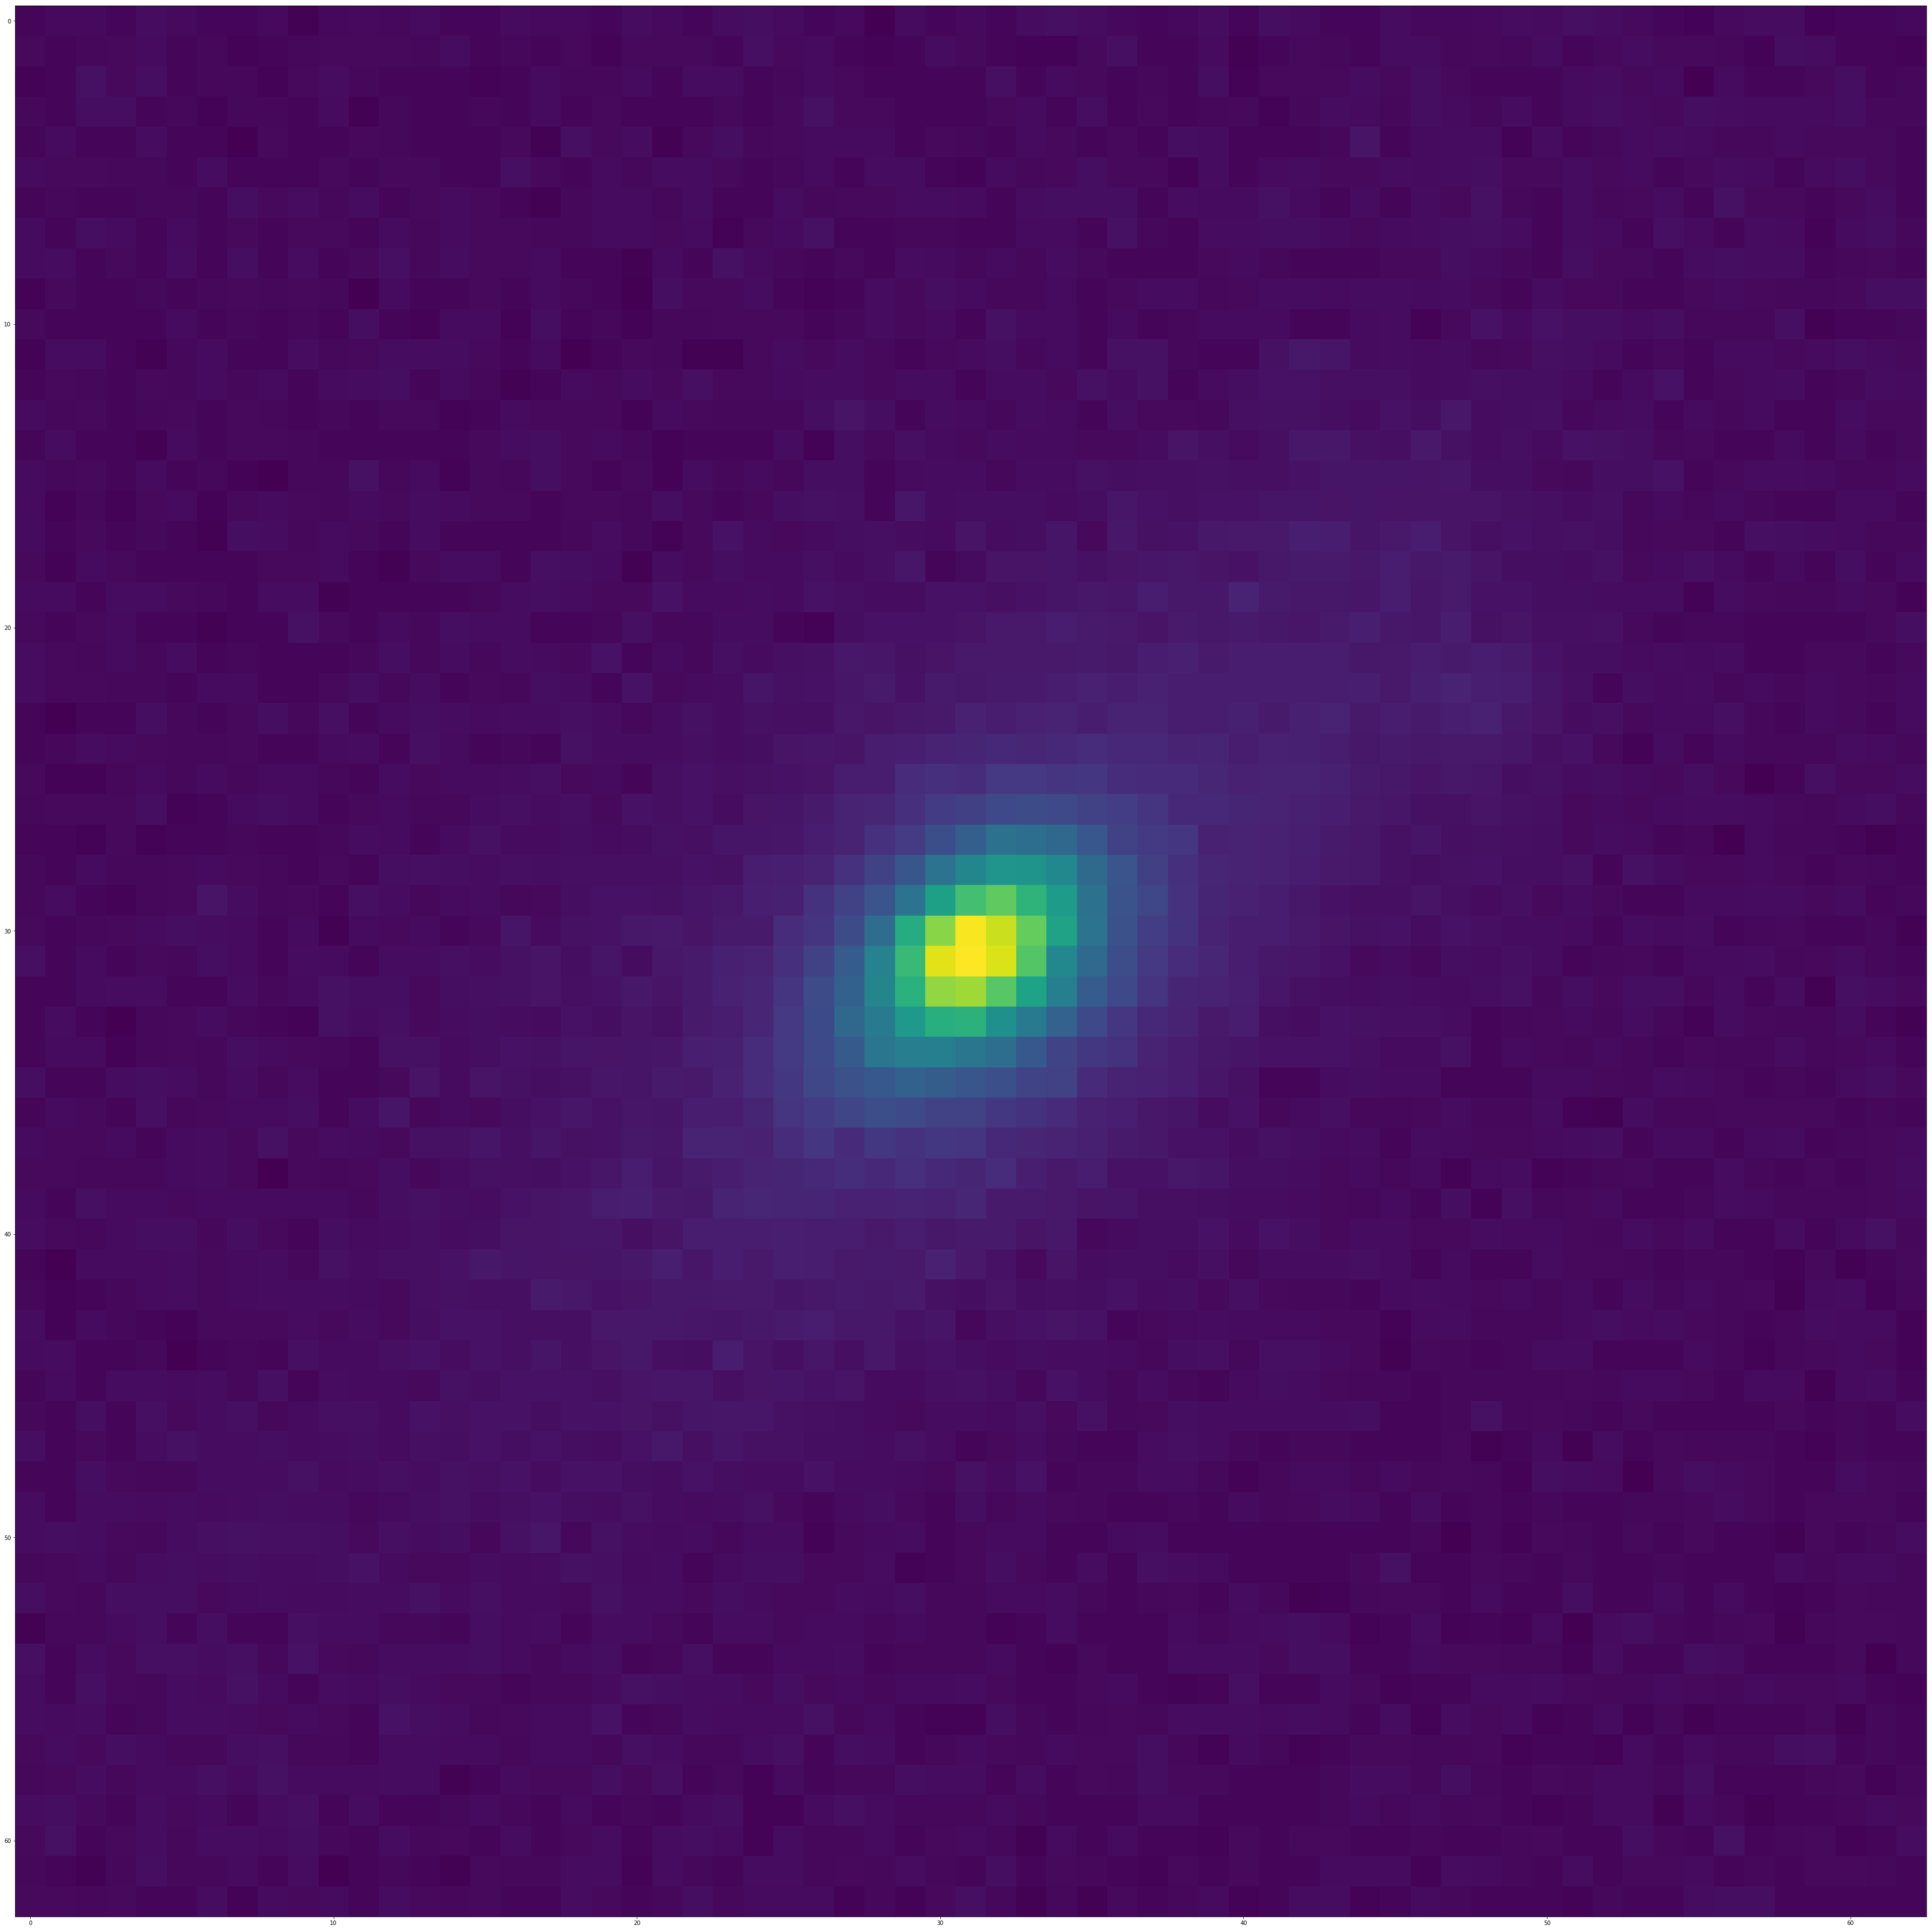

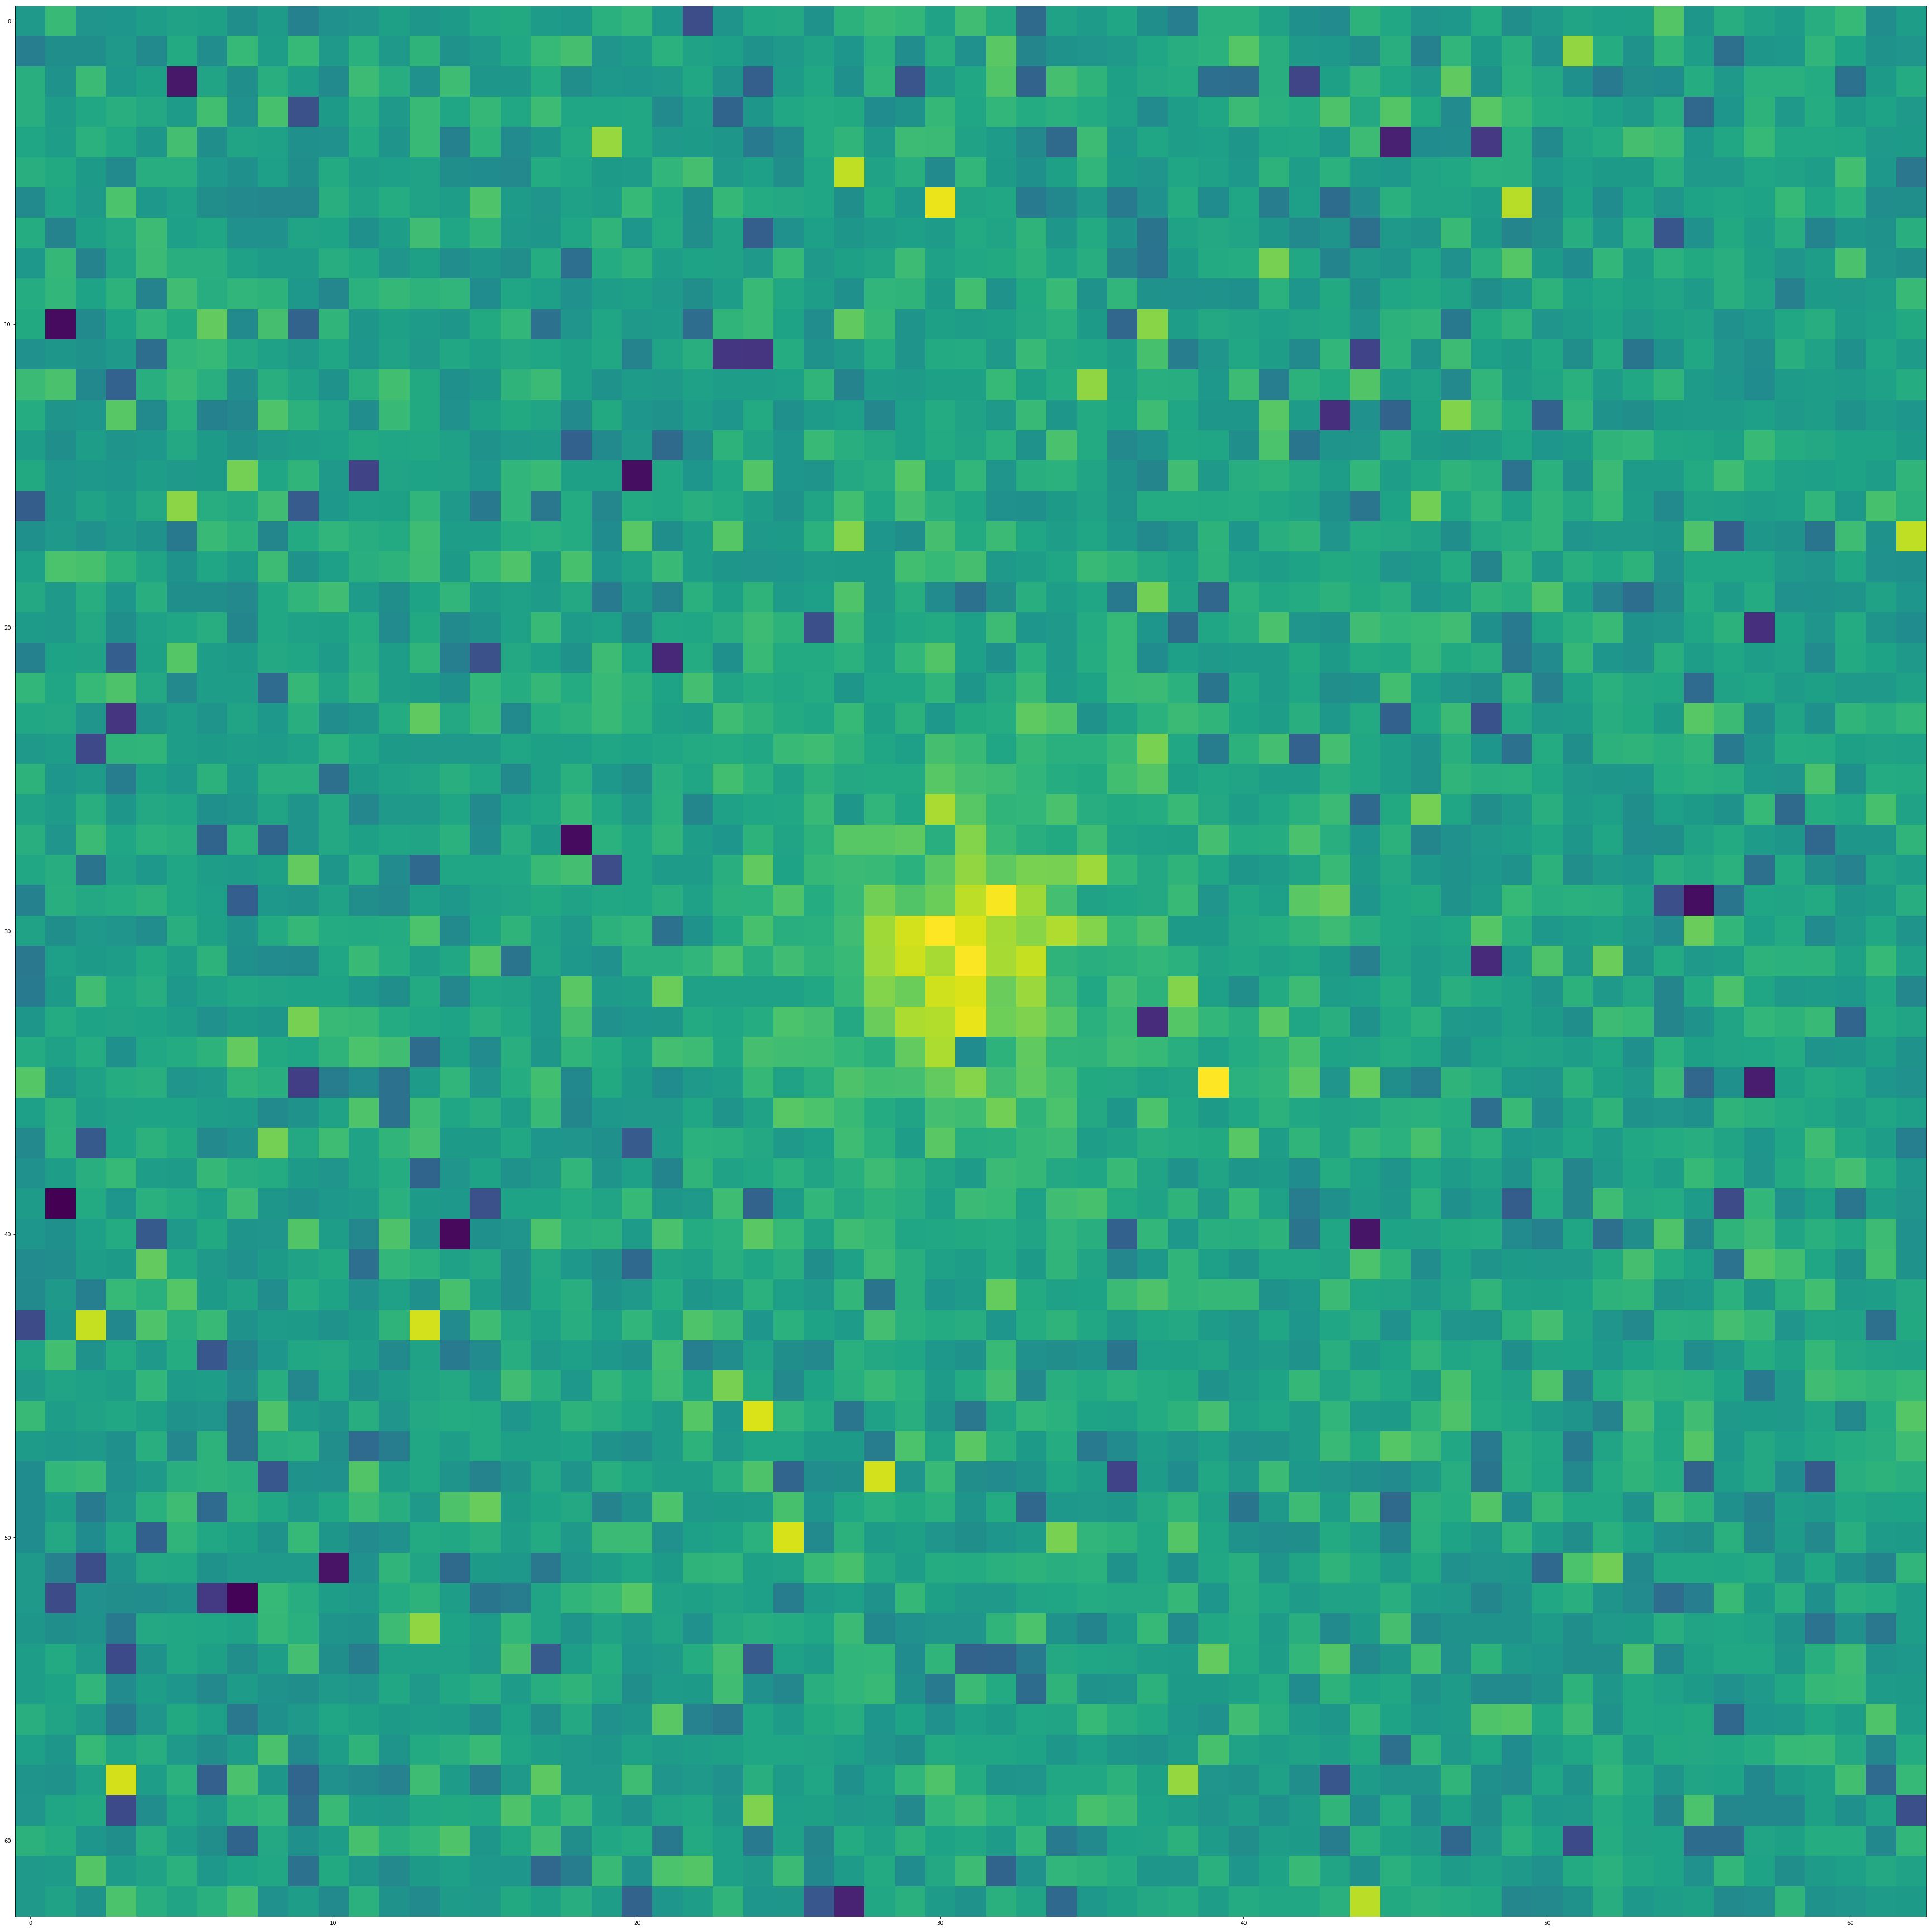

In [40]:
if decode:
    reconstruct_image(input_data[1],3)